<a href="https://colab.research.google.com/github/sopkart/ai-workshop-summer-2022/blob/main/Decision_Tree_From_Scratch_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

mush_train = pd.read_csv('mush_train.data', header=None)
print(mush_train.head(10))
mush_train = mush_train.to_numpy()
print(mush_train.shape)

mush_test = pd.read_csv('mush_test.data', header=None)
print(mush_test.head(10))
mush_test = mush_test.to_numpy()
print(mush_test.shape)

In [ ]:
X_train = mush_train[:, 1:]
Y_train = mush_train[:, 0]

X_test = mush_test[:, 1:]
Y_test = mush_test[:, 0]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

1. Assuming you break ties using the attribute that occurs last (left to right) in the data, draw
the resulting decision tree and report the maximum information gain for each node that you
added to the tree.


\begin{align}
\text{H}(Y) = - \sum_{y} p(Y = y)\log p(Y = y)
\end{align}

\begin{align}
\text{H}(Y|X) = - \sum_{x} p(X = x)\sum_{y}p(Y=y|X=x)\log p(Y=y|X=x)
\end{align}

$$\text{IG}(X) = \text{H}(Y) - \text{H}(Y|X)$$

In [ ]:
# Constructing decision tree

class Node():

  def __init__(self, X, Y, parent, isInternal = True, branched_at=None):
    self.X = X
    self.Y = Y
    self.parent = parent
    self.isInternal = isInternal
    self.child = []
    self.IG = 0
    self.branched_at = branched_at

    if(len(set(Y)) == 1):
      self.leaf = True
      self.label = Y[0]
    else:
      self.leaf = False
      self.label = 'not a leaf'

    if((parent == None or isInternal) and (not self.leaf)):
      self.branch()


  def cond_entropy(self, xi):
    H_YXi = 0
    for cat in set(self.X[:, xi]):  #pick the column representing the attribute 'xi'
      Y_cat = self.Y[np.where(self.X[:, xi] == cat)]   #count of Y given each discrete value of xi
      e = len(np.where(Y_cat == 'e')[0]) / Y_cat.shape[0]  #p(Y='e')
      p = len(np.where(Y_cat == 'p')[0]) / Y_cat.shape[0]  #p(Y='p')
      p = len(np.where(Y_cat == 'p')[0]) / Y_cat.shape[0]
      H_YXi -= (Y_cat.shape[0]/ self.Y.shape[0]) * (np.log(e**e) + np.log(p**p))   #H(Y|X)

    return H_YXi


  def branch(self):
    e = len(np.where(self.Y == 'e')[0]) / self.Y.shape[0]  #p(Y='e')
    p = len(np.where(self.Y == 'p')[0]) / self.Y.shape[0]  #p(Y='p')
    H_Y = -(np.log(e**e) + np.log(p**p))

    if(self.branched_at == None):
      max_gain = 0
      for xi in range(self.X.shape[1]):
        H_Yxi = self.cond_entropy(xi)
        IG =  H_Y - H_Yxi
        if (IG > max_gain) or (IG == max_gain and self.branched_at < xi):  #break ties
          max_gain = IG
          self.branched_at = xi
    else:
      max_gain = H_Y - self.cond_entropy(self.branched_at)

    self.IG = max_gain
    self.label = 'IG= ' + str(np.round(max_gain, 3)) + '\n at' + str(self.branched_at)

    for cat in set(self.X[:, self.branched_at]):
      X_c = self.X[np.where(self.X[:, self.branched_at] == cat)[0], :]
      Y_c = self.Y[np.where(self.X[:, self.branched_at] == cat)[0]]
      new_node = Node(X_c, Y_c, self, self.isInternal)
      self.child.append(new_node)



In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

def plot_tree(main_node, index, dim):

  def dfs(mnode, pre_index):
    for node in mnode.child:
      index = node.label
      if(index in {'e', 'p'}):
        index = str(mnode.branched_at) + node.X[0, mnode.branched_at] + ' -> ' + index
      else:
        index = str(mnode.branched_at) + node.X[0, mnode.branched_at] + '\n' + index

      Graph.add_node(index)
      Graph.add_edge(pre_index, index)
      dfs(node, index)

  Graph = nx.DiGraph()
  Graph.add_node(main_node.label)
  dfs(main_node, index)
  pos = graphviz_layout(Graph, prog='dot')
  plt.figure(figsize=dim)
  nx.draw(Graph, pos, with_labels=True, font_weight='bold', node_color='skyblue', alpha=1, node_size=1600)
  plt.show()

In [ ]:
main_node = Node(X_train, Y_train, None)


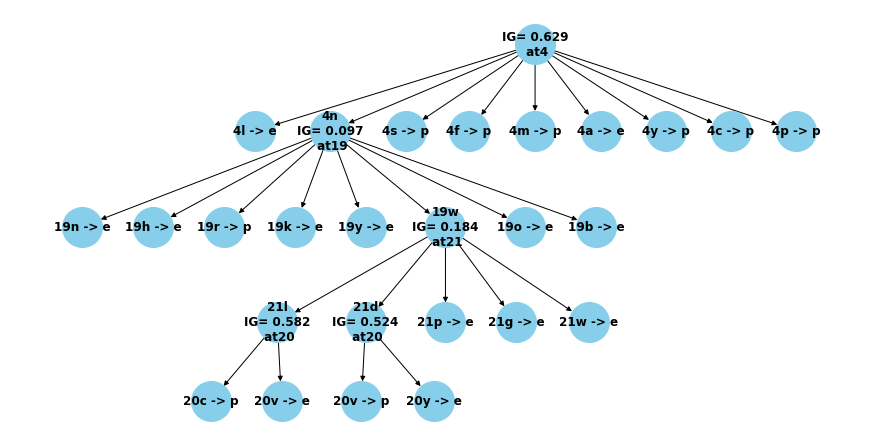

In [ ]:
plot_tree(main_node, main_node.label, [12, 6])

In [ ]:
def predict(X, main_node):
  Y_pred = []

  for i in range(X.shape[0]):
    cur_node = main_node

    while True:
      if (cur_node.label in set(Y_train)):
        Y_pred.append(cur_node.label)
        break
      else:
        flag = 0
        for node in cur_node.child:
          check = list(set(node.X[:, cur_node.branched_at]))[0]
          if(X[i, cur_node.branched_at] == check):
            cur_node = node
            flag = 1
            break
        if(flag == 0):
          Y_pred.append('Not found')
          break
  return Y_pred


In [ ]:
print(predict(X_test[:10, :], main_node))

['p', 'p', 'p', 'e', 'p', 'p', 'p', 'e', 'p', 'e']
